# Data Collection

Install Library

In [ ]:
pip install requests beautifulsoup4 lxml

Import Library

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime

Read Ridership Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ridership_df = pd.read_csv('/content/drive/MyDrive/WIH2001_DA_Group_Project/ridership_headline.csv')
ridership_df.head()

date  bus_rkl  bus_rkn  bus_rpn  rail_lrt_ampang  rail_mrt_kajang  \
0  2019-01-01      NaN      NaN      NaN           113357           114173   
1  2019-01-02      NaN      NaN      NaN           182715           169316   
2  2019-01-03      NaN      NaN      NaN           187904           175304   
3  2019-01-04      NaN      NaN      NaN           198420           187891   
4  2019-01-05      NaN      NaN      NaN           120773           112660   

   rail_lrt_kj  rail_monorail  rail_mrt_pjy  rail_ets  rail_intercity  \
0       139634          35804           NaN       NaN             NaN   
1       274224          31859           NaN       NaN             NaN   
2       286469          31893           NaN       NaN             NaN   
3       304755          34121           NaN       NaN             NaN   
4       145036          29950           NaN       NaN             NaN   

   rail_komuter_utara  rail_tebrau  rail_komuter  
0                 NaN          NaN           NaN  
1                 NaN          NaN           NaN  
2                 NaN          NaN           NaN  
3                 NaN          NaN           NaN  
4                 NaN          NaN           NaN

Web Scrapping -  Holiday Data from officeholidays.com

In [ ]:
# List of URLs for public holidays in Kuala Lumpur
urls = [
    'https://www.officeholidays.com/countries/malaysia/kuala-lumpur/2019',
    'https://www.officeholidays.com/countries/malaysia/kuala-lumpur/2020',
    'https://www.officeholidays.com/countries/malaysia/kuala-lumpur/2021',
    'https://www.officeholidays.com/countries/malaysia/kuala-lumpur/2022',
    'https://www.officeholidays.com/countries/malaysia/kuala-lumpur/2023',
    'https://www.officeholidays.com/countries/malaysia/kuala-lumpur/2024'
]

# Initialize an empty DataFrame to store all the holiday data
all_holidays = pd.DataFrame(columns=['Date', 'Holiday'])

# Function to scrape data from a single URL and append to DataFrame
def scrape_url(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
    else:
        print(f"Failed to retrieve the web page. Status code: {response.status_code}")
        return None

    # Find all the holiday rows in the table
    holiday_rows = soup.find_all('tr', class_=['region-past', 'country-past', 'country', 'region'])

    # Initialize lists to hold the dates and holiday names
    holiday_dates = []
    holiday_names = []

    # Extract holiday dates and names from each row
    for row in holiday_rows:
        date_element = row.find('time', itemprop='startDate')
        holiday_date = date_element['datetime']
        holiday_dates.append(holiday_date)

        # Extract holiday names
        holiday_name = row.find('a', class_='country-listing').text.strip()
        holiday_names.append(holiday_name)

    # Create a DataFrame for the current URL
    url_data = pd.DataFrame({
        'Date': holiday_dates,
        'Holiday': holiday_names
    })

    return url_data

# Loop through each URL, scrape data, and append to all_holidays DataFrame
for url in urls:
    holiday_data = scrape_url(url)
    if holiday_data is not None:
        all_holidays = pd.concat([all_holidays, holiday_data], ignore_index=True)

# Convert dates to the desired format "YYYY-MM-DD"
def format_date(date):
    try:
        return datetime.strptime(date, '%Y-%m-%d').strftime('%Y-%m-%d')
    except ValueError:
        return None

all_holidays['Formatted_Date'] = all_holidays['Date'].apply(format_date)
all_holidays = all_holidays.dropna(subset=['Formatted_Date'])  # Drop rows where date conversion failed

# Select only the formatted dates and holiday names
KL_public_Holiday = all_holidays[['Formatted_Date', 'Holiday']]

# Rename the columns
KL_public_Holiday.columns = ['Holiday_Date', 'Holiday_Name']

# Save to CSV
KL_public_Holiday.to_csv('/content/drive/MyDrive/WIH2001_DA_Group_Project/KL_public_Holiday.csv', index=False)

# View the DataFrame (Optional)
print(KL_public_Holiday)

    Holiday_Date              Holiday_Name
0     2019-01-01            New Year's Day
1     2019-01-21                 Thaipusam
2     2019-02-01     Federal Territory Day
3     2019-02-05          Chinese New Year
4     2019-02-06  Chinese New Year Holiday
..           ...                       ...
120   2024-08-31              National Day
121   2024-09-16              Malaysia Day
122   2024-09-16            Maulidur Rasul
123   2024-10-31                 Deepavali
124   2024-12-25             Christmas Day

[125 rows x 2 columns]


Create a new column 'public_Holiday' in ridership dataset

In [ ]:
# Create new column 'public_Holiday' in the ridership dataset
ridership_df['public_Holiday'] = 'No'

# Iterate over the dates in the ridership dataset and compare with the date in KL_public_Holiday dataset
for index, row in ridership_df.iterrows():
  if row['date'] in KL_public_Holiday['Holiday_Date'].values:
    ridership_df.at[index, 'public_Holiday'] = 'Yes'

# Save updated dataset to a new CSV file
ridership_df.to_csv('/content/drive/MyDrive/WIH2001_DA_Group_Project/merged_ridership_df.csv', index = False)

display(ridership_df)

date   bus_rkl  bus_rkn  bus_rpn  rail_lrt_ampang  \
0     2019-01-01       NaN      NaN      NaN           113357   
1     2019-01-02       NaN      NaN      NaN           182715   
2     2019-01-03       NaN      NaN      NaN           187904   
3     2019-01-04       NaN      NaN      NaN           198420   
4     2019-01-05       NaN      NaN      NaN           120773   
...          ...       ...      ...      ...              ...   
1912  2024-03-27  201893.0   2838.0  42623.0           195860   
1913  2024-03-28  114897.0   1808.0  33983.0           123967   
1914  2024-03-29  182897.0   2958.0  42235.0           182922   
1915  2024-03-30  118919.0   2011.0  35542.0           136787   
1916  2024-03-31  112301.0   2201.0  39910.0           118616   

      rail_mrt_kajang  rail_lrt_kj  rail_monorail  rail_mrt_pjy  rail_ets  \
0              114173       139634          35804           NaN       NaN   
1              169316       274224          31859           NaN       NaN   
2              175304       286469          31893           NaN       NaN   
3              187891       304755          34121           NaN       NaN   
4              112660       145036          29950           NaN       NaN   
...               ...          ...            ...           ...       ...   
1912           251996       278863          55175      149236.0   10325.0   
1913           156908       138478          38093       79863.0   10588.0   
1914           227034       241375          53130      132224.0   11529.0   
1915           161181       145586          46335       80600.0   11645.0   
1916           136166       123186          40731       66271.0   11959.0   

      rail_intercity  rail_komuter_utara  rail_tebrau  rail_komuter  \
0                NaN                 NaN          NaN           NaN   
1                NaN                 NaN          NaN           NaN   
2                NaN                 NaN          NaN           NaN   
3                NaN                 NaN          NaN           NaN   
4                NaN                 NaN          NaN           NaN   
...              ...                 ...          ...           ...   
1912          2616.0             10430.0       9630.0       38070.0   
1913          2626.0             10522.0       9120.0       20236.0   
1914          2464.0             12375.0       8334.0       37604.0   
1915          3281.0             10464.0       8654.0       23345.0   
1916          2582.0             12312.0       7900.0       22966.0   

     public_Holiday  
0               Yes  
1                No  
2                No  
3                No  
4                No  
...             ...  
1912             No  
1913            Yes  
1914             No  
1915             No  
1916             No  

[1917 rows x 15 columns]

Read Covid-19 data

In [ ]:
covid_df = pd.read_csv('/content/drive/MyDrive/WIH2001_DA_Group_Project/Covid-19_dates.csv')
covid_df.head()

# Convert 'datetime' column to datetime format
covid_df['Covid_19_dates'] = pd.to_datetime(covid_df['Covid_19_dates'], format='%Y-%m-%d')

# Format 'datetime' column to 'YYYY-MM-DD'
covid_df['Covid_19_dates'] = covid_df['Covid_19_dates'].dt.strftime('%Y-%m-%d')

# Create new column 'covid' in the ridership dataset
ridership_df['covid'] = 'No'

# Iterate over the dates in the ridership dataset and compare with the date in covid dataset
for index, row in ridership_df.iterrows():
  if row['date'] in covid_df['Covid_19_dates'].values:
    ridership_df.at[index, 'covid'] = 'Yes'

# Save updated dataset to a new CSV file
ridership_df.to_csv('/content/drive/MyDrive/WIH2001_DA_Group_Project/merged_ridership_df.csv', index = False)

display(ridership_df)

date   bus_rkl  bus_rkn  bus_rpn  rail_lrt_ampang  \
0     2019-01-01       NaN      NaN      NaN           113357   
1     2019-01-02       NaN      NaN      NaN           182715   
2     2019-01-03       NaN      NaN      NaN           187904   
3     2019-01-04       NaN      NaN      NaN           198420   
4     2019-01-05       NaN      NaN      NaN           120773   
...          ...       ...      ...      ...              ...   
1912  2024-03-27  201893.0   2838.0  42623.0           195860   
1913  2024-03-28  114897.0   1808.0  33983.0           123967   
1914  2024-03-29  182897.0   2958.0  42235.0           182922   
1915  2024-03-30  118919.0   2011.0  35542.0           136787   
1916  2024-03-31  112301.0   2201.0  39910.0           118616   

      rail_mrt_kajang  rail_lrt_kj  rail_monorail  rail_mrt_pjy  rail_ets  \
0              114173       139634          35804           NaN       NaN   
1              169316       274224          31859           NaN       NaN   
2              175304       286469          31893           NaN       NaN   
3              187891       304755          34121           NaN       NaN   
4              112660       145036          29950           NaN       NaN   
...               ...          ...            ...           ...       ...   
1912           251996       278863          55175      149236.0   10325.0   
1913           156908       138478          38093       79863.0   10588.0   
1914           227034       241375          53130      132224.0   11529.0   
1915           161181       145586          46335       80600.0   11645.0   
1916           136166       123186          40731       66271.0   11959.0   

      rail_intercity  rail_komuter_utara  rail_tebrau  rail_komuter  \
0                NaN                 NaN          NaN           NaN   
1                NaN                 NaN          NaN           NaN   
2                NaN                 NaN          NaN           NaN   
3                NaN                 NaN          NaN           NaN   
4                NaN                 NaN          NaN           NaN   
...              ...                 ...          ...           ...   
1912          2616.0             10430.0       9630.0       38070.0   
1913          2626.0             10522.0       9120.0       20236.0   
1914          2464.0             12375.0       8334.0       37604.0   
1915          3281.0             10464.0       8654.0       23345.0   
1916          2582.0             12312.0       7900.0       22966.0   

     public_Holiday covid  
0               Yes    No  
1                No    No  
2                No    No  
3                No    No  
4                No    No  
...             ...   ...  
1912             No    No  
1913            Yes    No  
1914             No    No  
1915             No    No  
1916             No    No  

[1917 rows x 16 columns]

Read Weather Data of Kuala Lumpur

In [ ]:
weather_df = pd.read_csv('/content/drive/MyDrive/WIH2001_DA_Group_Project/kuala lumpur 2019-01-01 to 2024-04-30.csv')
weather_df.head()

df = pd.DataFrame(weather_df)

# List of columns to keep
columns_to_keep = ['datetime', 'feelslike', 'uvindex', 'preciptype']

# Create a new DataFrame with only the columns to keep
df_new = df[columns_to_keep]

# Display the DataFrame after keeping only the specified columns
print(df_new)

       datetime  feelslike  uvindex preciptype
0      1/1/2019       30.4        9       rain
1      2/1/2019       30.5        9       rain
2      3/1/2019       31.3        9        NaN
3      4/1/2019       31.5        9        NaN
4      5/1/2019       32.0        9        NaN
...         ...        ...      ...        ...
1942  26/4/2024       32.3        8       rain
1943  27/4/2024       33.0        9       rain
1944  28/4/2024       35.8        9       rain
1945  29/4/2024       36.1       10       rain
1946  30/4/2024       33.7        9       rain

[1947 rows x 4 columns]


In [ ]:
# Convert 'datetime' column to datetime format
df_new['datetime'] = pd.to_datetime(df_new['datetime'], format='%d/%m/%Y')

# Format 'datetime' column to 'YYYY-MM-DD'
df_new['datetime'] = df_new['datetime'].dt.strftime('%Y-%m-%d')

# Display the DataFrame with formatted dates
print("\nDataFrame with formatted 'datetime' column:")
print(df_new)


DataFrame with formatted 'datetime' column:
        datetime  feelslike  uvindex preciptype
0     2019-01-01       30.4        9       rain
1     2019-01-02       30.5        9       rain
2     2019-01-03       31.3        9        NaN
3     2019-01-04       31.5        9        NaN
4     2019-01-05       32.0        9        NaN
...          ...        ...      ...        ...
1942  2024-04-26       32.3        8       rain
1943  2024-04-27       33.0        9       rain
1944  2024-04-28       35.8        9       rain
1945  2024-04-29       36.1       10       rain
1946  2024-04-30       33.7        9       rain

[1947 rows x 4 columns]


<ipython-input-10-8f8d8b8b580e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['datetime'] = pd.to_datetime(df_new['datetime'], format='%d/%m/%Y')
<ipython-input-10-8f8d8b8b580e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['datetime'] = df_new['datetime'].dt.strftime('%Y-%m-%d')


In [ ]:
# Merge df_new (weather data) with ridership_df
ridership_df = pd.merge(ridership_df, df_new, left_on='date', right_on='datetime', how='left')

# Drop the redundant 'datetime' column from the merged DataFrame
ridership_df = ridership_df.drop(columns=['datetime'])

# Save the merged DataFrame to a new CSV file
ridership_df.to_csv('/content/drive/MyDrive/WIH2001_DA_Group_Project/merged_ridership_df.csv', index=False)

# Display the merged DataFrame
print("Merged DataFrame (Ridership and Weather Data):")
print(ridership_df)

Merged DataFrame (Ridership and Weather Data):
            date   bus_rkl  bus_rkn  bus_rpn  rail_lrt_ampang  \
0     2019-01-01       NaN      NaN      NaN           113357   
1     2019-01-02       NaN      NaN      NaN           182715   
2     2019-01-03       NaN      NaN      NaN           187904   
3     2019-01-04       NaN      NaN      NaN           198420   
4     2019-01-05       NaN      NaN      NaN           120773   
...          ...       ...      ...      ...              ...   
1912  2024-03-27  201893.0   2838.0  42623.0           195860   
1913  2024-03-28  114897.0   1808.0  33983.0           123967   
1914  2024-03-29  182897.0   2958.0  42235.0           182922   
1915  2024-03-30  118919.0   2011.0  35542.0           136787   
1916  2024-03-31  112301.0   2201.0  39910.0           118616   

      rail_mrt_kajang  rail_lrt_kj  rail_monorail  rail_mrt_pjy  rail_ets  \
0              114173       139634          35804           NaN       NaN   
1              169

In [ ]:
# Get the count of each unique condition
preciptype_counts = ridership_df['preciptype'].value_counts()

# Print the condition counts
print("Preciptype Counts:")
print(preciptype_counts)

Preciptype Counts:
preciptype
rain    1485
Name: count, dtype: int64


# Data Cleaning

Read merged dataset

In [ ]:
ridership_df = pd.read_csv('/content/drive/MyDrive/WIH2001_DA_Group_Project/merged_ridership_df.csv')
ridership_df.head()

date  bus_rkl  bus_rkn  bus_rpn  rail_lrt_ampang  rail_mrt_kajang  \
0  2019-01-01      NaN      NaN      NaN           113357           114173   
1  2019-01-02      NaN      NaN      NaN           182715           169316   
2  2019-01-03      NaN      NaN      NaN           187904           175304   
3  2019-01-04      NaN      NaN      NaN           198420           187891   
4  2019-01-05      NaN      NaN      NaN           120773           112660   

   rail_lrt_kj  rail_monorail  rail_mrt_pjy  rail_ets  rail_intercity  \
0       139634          35804           NaN       NaN             NaN   
1       274224          31859           NaN       NaN             NaN   
2       286469          31893           NaN       NaN             NaN   
3       304755          34121           NaN       NaN             NaN   
4       145036          29950           NaN       NaN             NaN   

   rail_komuter_utara  rail_tebrau  rail_komuter public_Holiday covid  \
0                 NaN          NaN           NaN            Yes    No   
1                 NaN          NaN           NaN             No    No   
2                 NaN          NaN           NaN             No    No   
3                 NaN          NaN           NaN             No    No   
4                 NaN          NaN           NaN             No    No   

   feelslike  uvindex preciptype  
0       30.4        9       rain  
1       30.5        9       rain  
2       31.3        9        NaN  
3       31.5        9        NaN  
4       32.0        9        NaN

Check the null value of the data

In [ ]:
ridership_df.isnull().sum()

date                     0
bus_rkl               1096
bus_rkn               1096
bus_rpn               1096
rail_lrt_ampang          0
rail_mrt_kajang          0
rail_lrt_kj              0
rail_monorail            0
rail_mrt_pjy          1262
rail_ets               653
rail_intercity         653
rail_komuter_utara     653
rail_tebrau           1265
rail_komuter          1734
public_Holiday           0
covid                    0
feelslike                0
uvindex                  0
preciptype             432
dtype: int64

:Remove all Public Transport Lines that are not in Klang Valley

In [ ]:
ridership_df = ridership_df.drop(['bus_rkn', 'bus_rpn', 'rail_ets', 'rail_intercity', 'rail_komuter_utara', 'rail_tebrau', 'rail_komuter'], axis = 1)

In [ ]:
ridership_df.head()

date  bus_rkl  rail_lrt_ampang  rail_mrt_kajang  rail_lrt_kj  \
0  2019-01-01      NaN           113357           114173       139634   
1  2019-01-02      NaN           182715           169316       274224   
2  2019-01-03      NaN           187904           175304       286469   
3  2019-01-04      NaN           198420           187891       304755   
4  2019-01-05      NaN           120773           112660       145036   

   rail_monorail  rail_mrt_pjy public_Holiday covid  feelslike  uvindex  \
0          35804           NaN            Yes    No       30.4        9   
1          31859           NaN             No    No       30.5        9   
2          31893           NaN             No    No       31.3        9   
3          34121           NaN             No    No       31.5        9   
4          29950           NaN             No    No       32.0        9   

  preciptype  
0       rain  
1       rain  
2        NaN  
3        NaN  
4        NaN

Check Duplicate data

In [ ]:
duplicates = ridership_df[ridership_df.duplicated()]
duplicates

Empty DataFrame
Columns: [date, bus_rkl, rail_lrt_ampang, rail_mrt_kajang, rail_lrt_kj, rail_monorail, rail_mrt_pjy, public_Holiday, covid, feelslike, uvindex, preciptype]
Index: []

# Data Preprocessing

Rename Column 'preciptype' to 'rain'

In [ ]:
ridership_df.rename(columns={'preciptype': 'rain'}, inplace=True)

Transform Categorical Data to Numberical by Laber Encoder

In [ ]:
import numpy as np

# Replace values in 'public_Holiday' column: 'Yes' -> 1, 'No' -> 0
mapping = {'Yes': 1, 'No': 0}
ridership_df['public_Holiday'] = ridership_df['public_Holiday'].map(mapping).fillna(0).astype(int)

# Replace values in 'covid' column: 'Yes' -> 1, 'No' -> 0
mapping = {'Yes': 1, 'No': 0}
ridership_df['covid'] = ridership_df['covid'].map(mapping).fillna(0).astype(int)

# Replace values in 'rain' column: 'rain' -> 1, others -> 0
mapping = {'rain': 1, np.nan: 0}
ridership_df['rain'] = ridership_df['rain'].map(mapping).fillna(0).astype(int)

In [ ]:
ridership_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917 entries, 0 to 1916
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             1917 non-null   object 
 1   bus_rkl          821 non-null    float64
 2   rail_lrt_ampang  1917 non-null   int64  
 3   rail_mrt_kajang  1917 non-null   int64  
 4   rail_lrt_kj      1917 non-null   int64  
 5   rail_monorail    1917 non-null   int64  
 6   rail_mrt_pjy     655 non-null    float64
 7   public_Holiday   1917 non-null   int64  
 8   covid            1917 non-null   int64  
 9   feelslike        1917 non-null   float64
 10  uvindex          1917 non-null   int64  
 11  rain             1917 non-null   int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 179.8+ KB


Change 'date' to Date type

In [ ]:
# Convert 'Date' column to datetime type
ridership_df['date'] = pd.to_datetime(ridership_df['date'], format='%Y-%m-%d')
ridership_df['date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1917 entries, 0 to 1916
Series name: date
Non-Null Count  Dtype         
--------------  -----         
1917 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 15.1 KB


Change 'bus_rkl' & 'rail_mrt_pjy' from float64 to int64

In [ ]:
# Fill missing values with 0
ridership_df['bus_rkl'].fillna(0, inplace=True)
ridership_df['rail_mrt_pjy'].fillna(0, inplace=True)

# Convert the columns to int64
ridership_df['bus_rkl'] = ridership_df['bus_rkl'].astype('int64')
ridership_df['rail_mrt_pjy'] = ridership_df['rail_mrt_pjy'].astype('int64')

ridership_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917 entries, 0 to 1916
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1917 non-null   datetime64[ns]
 1   bus_rkl          1917 non-null   int64         
 2   rail_lrt_ampang  1917 non-null   int64         
 3   rail_mrt_kajang  1917 non-null   int64         
 4   rail_lrt_kj      1917 non-null   int64         
 5   rail_monorail    1917 non-null   int64         
 6   rail_mrt_pjy     1917 non-null   int64         
 7   public_Holiday   1917 non-null   int64         
 8   covid            1917 non-null   int64         
 9   feelslike        1917 non-null   float64       
 10  uvindex          1917 non-null   int64         
 11  rain             1917 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(10)
memory usage: 179.8 KB


In [ ]:
ridership_df[ridership_df['covid'] == 1]

date  bus_rkl  rail_lrt_ampang  rail_mrt_kajang  rail_lrt_kj  \
442  2020-03-18        0            59073            47917        78308   
443  2020-03-19        0            41991            34138        56173   
444  2020-03-20        0            31881            25579        41850   
445  2020-03-21        0            15277            11377        17465   
446  2020-03-22        0             9517             7338        10477   
...         ...      ...              ...              ...          ...   
1017 2021-10-14        0            72675            64862        84689   
1018 2021-10-15        0            74170            67456        86445   
1019 2021-10-16        0            56012            51048        61053   
1020 2021-10-17        0            45945            44486        50456   
1021 2021-10-18        0            71434            64118        82533   

      rail_monorail  rail_mrt_pjy  public_Holiday  covid  feelslike  uvindex  \
442           10388             0               0      1       34.8        8   
443            7188             0               0      1       33.5        8   
444            5567             0               0      1       33.3        8   
445            3050             0               0      1       30.8        9   
446            2082             0               0      1       32.0        8   
...             ...           ...             ...    ...        ...      ...   
1017          12943             0               0      1       33.3        9   
1018          13940             0               0      1       32.8        9   
1019          12970             0               0      1       32.1        7   
1020          12171             0               0      1       29.5        7   
1021          13427             0               0      1       30.6        8   

      rain  
442      1  
443      1  
444      0  
445      1  
446      0  
...    ...  
1017     0  
1018     0  
1019     0  
1020     1  
1021     1  

[580 rows x 12 columns]

In [ ]:
ridership_df[ridership_df['public_Holiday'] == 1]

date  bus_rkl  rail_lrt_ampang  rail_mrt_kajang  rail_lrt_kj  \
0    2019-01-01        0           113357           114173       139634   
20   2019-01-21        0           103443           106077       125094   
31   2019-02-01        0           133281           134808       176585   
35   2019-02-05        0           102683            98115       142522   
36   2019-02-06        0            96384            91478       118858   
...         ...      ...              ...              ...          ...   
1857 2024-02-01   176200           110345           168370       155342   
1866 2024-02-10   168032           120724           183062       169787   
1867 2024-02-11   164656           127252           182602       165241   
1868 2024-02-12   140134           106837           161319       130448   
1913 2024-03-28   114897           123967           156908       138478   

      rail_monorail  rail_mrt_pjy  public_Holiday  covid  feelslike  uvindex  \
0             35804             0               1      0       30.4        9   
20            23836             0               1      0       30.7        8   
31            24817             0               1      0       32.7        9   
35            33484             0               1      0       32.1        9   
36            27009             0               1      0       32.2        9   
...             ...           ...             ...    ...        ...      ...   
1857          38708         81837               1      0       30.9        9   
1866          68149         93213               1      0       32.4        9   
1867          70687         90323               1      0       30.5       10   
1868          50706         81617               1      0       31.8       10   
1913          38093         79863               1      0       33.0        9   

      rain  
0        1  
20       1  
31       0  
35       1  
36       0  
...    ...  
1857     1  
1866     1  
1867     0  
1868     1  
1913     1  

[113 rows x 12 columns]

In [ ]:
# Save the cleaned DataFrame to a new CSV file
ridership_df.to_csv('/content/drive/MyDrive/WIH2001_DA_Group_Project/cleaned_ridership_df.csv', index=False)

# Data Visualization


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/WIH2001_DA_Group_Project/cleaned_ridership_df.csv')
df

date  bus_rkl  rail_lrt_ampang  rail_mrt_kajang  rail_lrt_kj  \
0     2019-01-01        0           113357           114173       139634   
1     2019-01-02        0           182715           169316       274224   
2     2019-01-03        0           187904           175304       286469   
3     2019-01-04        0           198420           187891       304755   
4     2019-01-05        0           120773           112660       145036   
...          ...      ...              ...              ...          ...   
1912  2024-03-27   201893           195860           251996       278863   
1913  2024-03-28   114897           123967           156908       138478   
1914  2024-03-29   182897           182922           227034       241375   
1915  2024-03-30   118919           136787           161181       145586   
1916  2024-03-31   112301           118616           136166       123186   

      rail_monorail  rail_mrt_pjy  public_Holiday  covid  feelslike  uvindex  \
0             35804             0               1      0       30.4        9   
1             31859             0               0      0       30.5        9   
2             31893             0               0      0       31.3        9   
3             34121             0               0      0       31.5        9   
4             29950             0               0      0       32.0        9   
...             ...           ...             ...    ...        ...      ...   
1912          55175        149236               0      0       34.1       10   
1913          38093         79863               1      0       33.0        9   
1914          53130        132224               0      0       32.5       10   
1915          46335         80600               0      0       31.6        9   
1916          40731         66271               0      0       30.9        8   

      rain  
0        1  
1        1  
2        0  
3        0  
4        0  
...    ...  
1912     1  
1913     1  
1914     1  
1915     1  
1916     1  

[1917 rows x 12 columns]

<Figure size 1400x800 with 0 Axes>

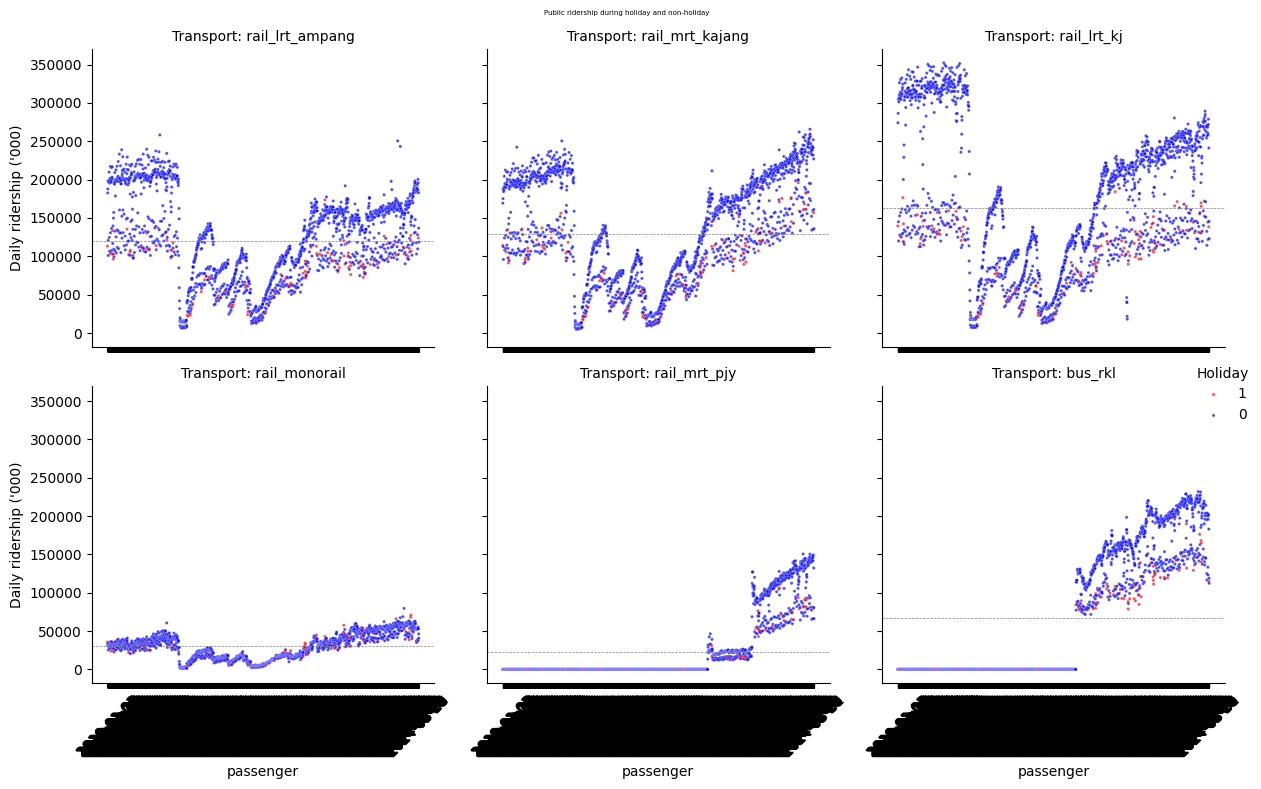

In [ ]:
# Melt the DataFrame to reshape it for plotting
data_melted = pd.melt(df, id_vars=['date', 'public_Holiday'],
                      value_vars=['rail_lrt_ampang', 'rail_mrt_kajang', 'rail_lrt_kj', 'rail_monorail', 'rail_mrt_pjy', 'bus_rkl'],
                      var_name='transport', value_name='passenger')

# Convert 'public_Holiday' column to string
data_melted['public_Holiday'] = data_melted['public_Holiday'].astype(str)

# Define a custom color palette to ensure different colors for the 'public_Holiday' categories
palette = {"0": "blue", "1": "red"}

# Plot using seaborn with facet grid
plt.figure(figsize=(14, 8))
g = sns.FacetGrid(data_melted, col='transport', col_wrap=3, height=4, aspect=1)
g.map_dataframe(sns.scatterplot, x='date', y='passenger', hue='public_Holiday', palette=palette, s=5, alpha=0.7)
g.set_axis_labels('Date', 'Daily ridership (\'000)')
g.set_titles('Transport: {col_name}')
g.add_legend(title='Holiday')

# Fix the legend manually to ensure colors match
for ax in g.axes.flatten():
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=['Non-Holiday', 'Holiday'], title='Holiday')
    ax.tick_params(axis='x', rotation=45)

# Add grid lines
g.map(lambda x, **kwargs: plt.axhline(x.mean(), **kwargs), 'passenger', color='gray', linestyle='--', linewidth=0.5)

# Set the title
g.fig.suptitle('Public ridership during holiday and non-holiday', fontsize=5)

plt.tight_layout()
plt.show()

<ipython-input-8-ef3daec4dfa6>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rain', y=mode, data=df, palette=["#4c72b0", "#55a868"])
<ipython-input-8-ef3daec4dfa6>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rain', y=mode, data=df, palette=["#4c72b0", "#55a868"])
<ipython-input-8-ef3daec4dfa6>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rain', y=mode, data=df, palette=["#4c72b0", "#55a868"])
<ipython-input-8-ef3daec4dfa6>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed

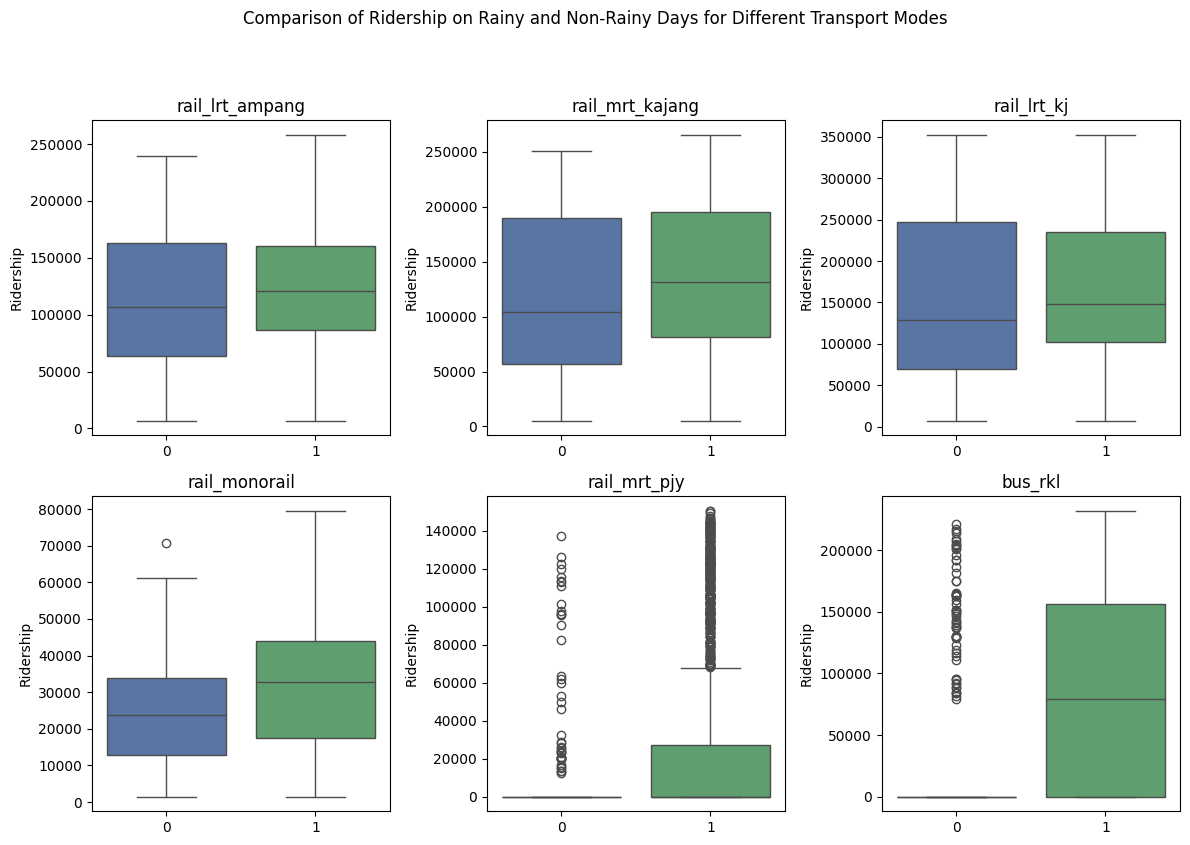

In [ ]:
# Define the list of transport modes
transport_modes = ['rail_lrt_ampang', 'rail_mrt_kajang', 'rail_lrt_kj', 'rail_monorail', 'rail_mrt_pjy', 'bus_rkl']

# Create separate dataframes for rainy and non-rainy days
rainy_days = df[df['rain'] > 0]
non_rainy_days = df[df['rain'] == 0]

# Create box plots for each transport mode, comparing ridership on rainy and non-rainy days
plt.figure(figsize=(12, 8))
for i, mode in enumerate(transport_modes, start=1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='rain', y=mode, data=df, palette=["#4c72b0", "#55a868"])
    plt.title(mode)
    plt.xlabel('')
    plt.ylabel('Ridership')

plt.suptitle('Comparison of Ridership on Rainy and Non-Rainy Days for Different Transport Modes', y=1.05)
plt.tight_layout()
plt.show()

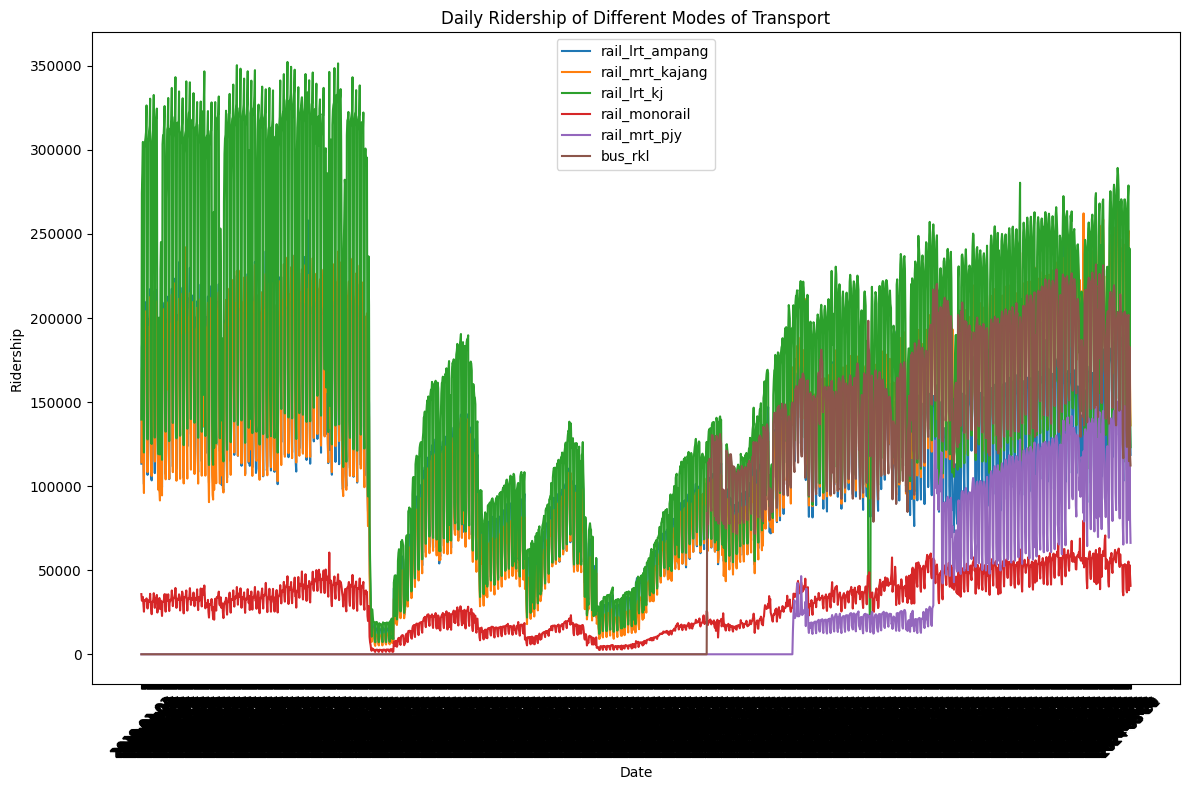

In [ ]:
# Define the list of transport modes
transport_modes = ['rail_lrt_ampang', 'rail_mrt_kajang', 'rail_lrt_kj', 'rail_monorail', 'rail_mrt_pjy', 'bus_rkl']

# Plot time series for each mode of transport
plt.figure(figsize=(12, 8))
for mode in transport_modes:
    sns.lineplot(x='date', y=mode, data=df, label=mode)

plt.title('Daily Ridership of Different Modes of Transport')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

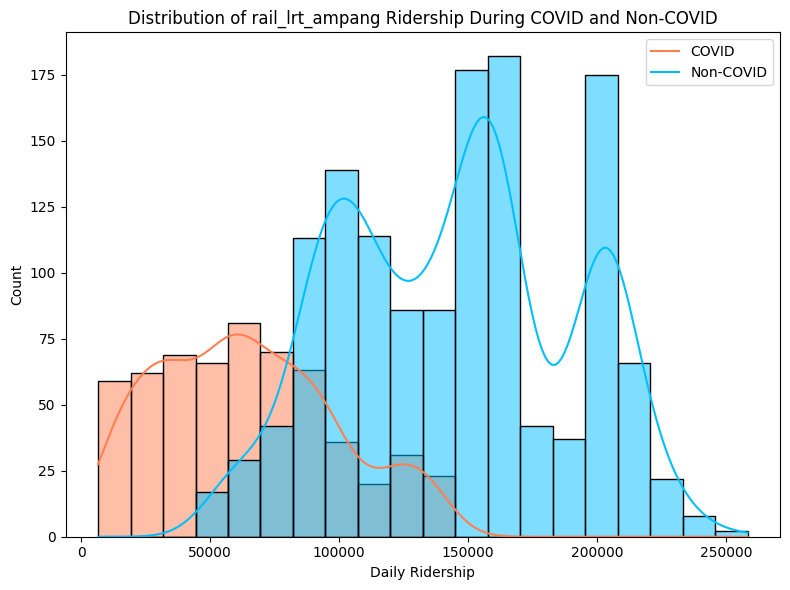

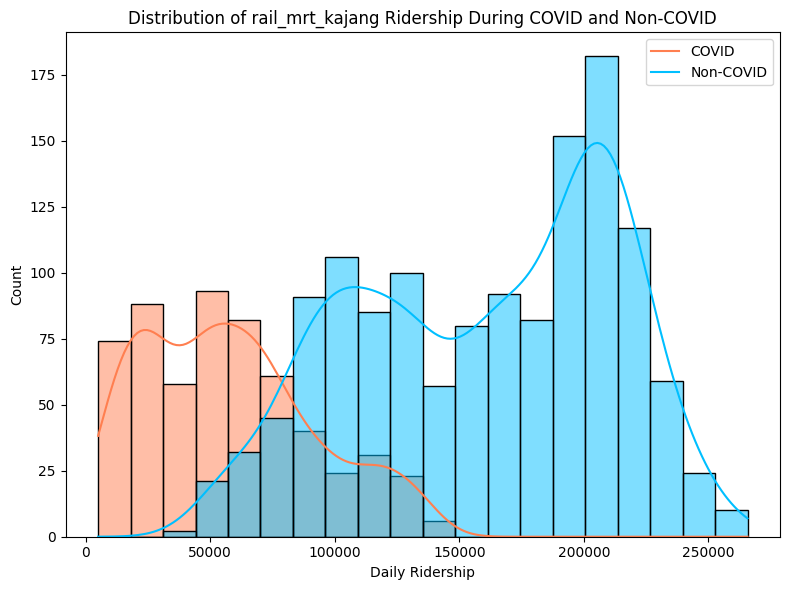

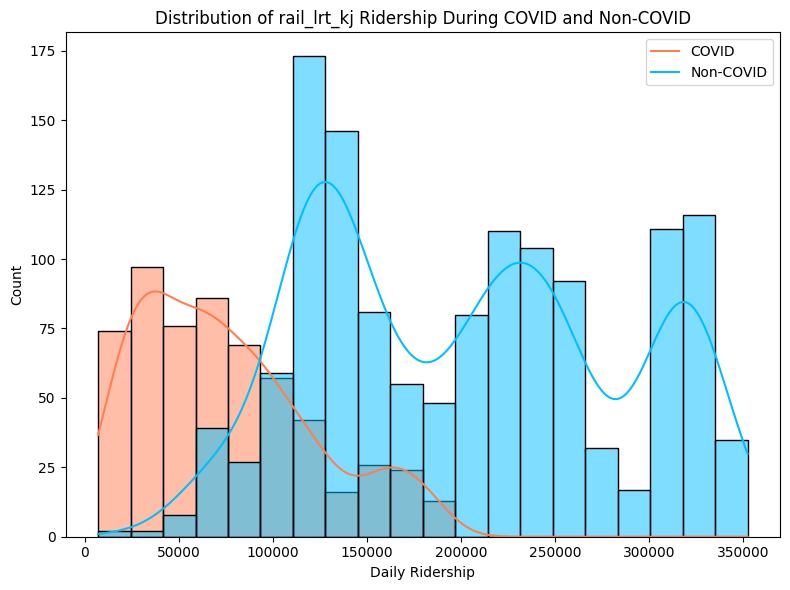

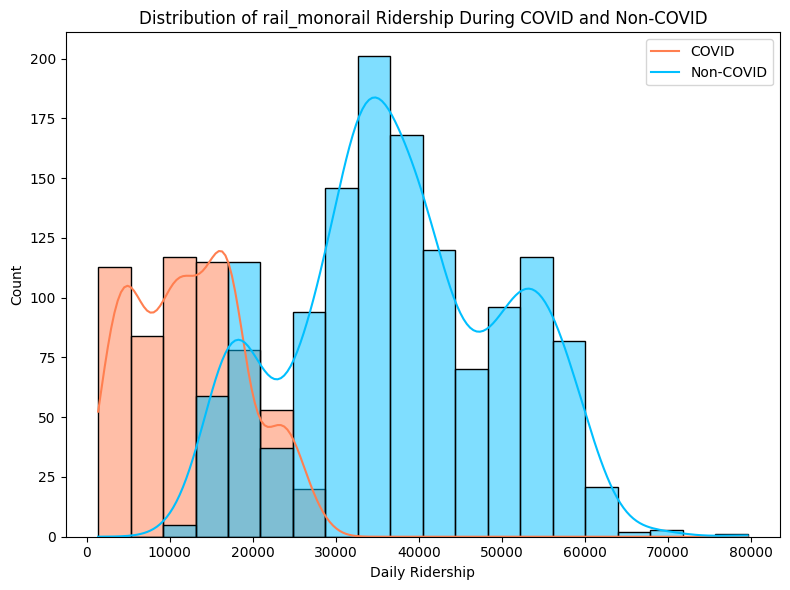

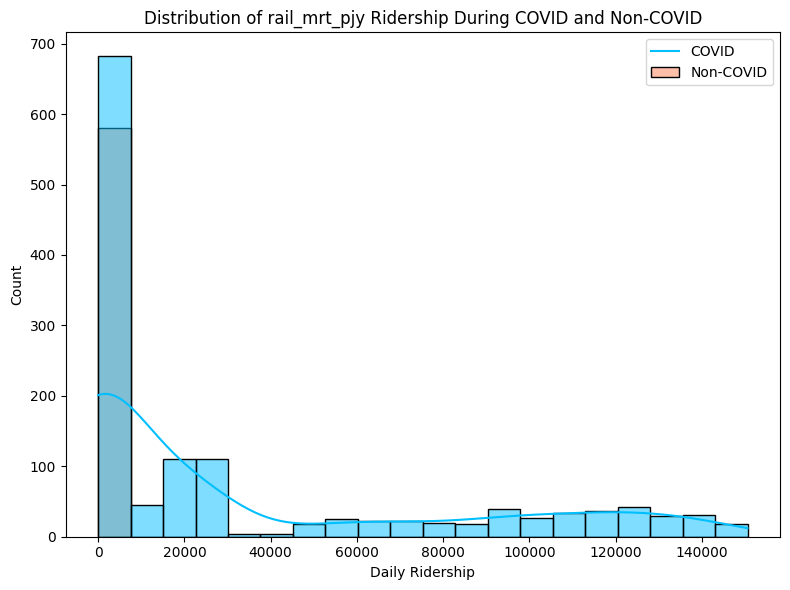

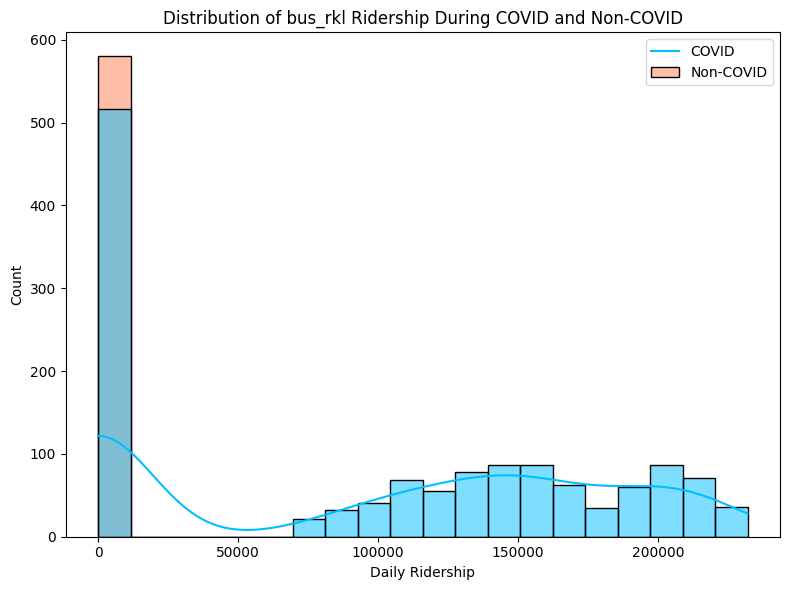

In [ ]:
# Convert 'covid' column to categorical with values '0' and '1'
df['covid'] = df['covid'].astype(str).astype('category')

# Define the list of transport modes
transport_modes = ['rail_lrt_ampang', 'rail_mrt_kajang', 'rail_lrt_kj',
                   'rail_monorail', 'rail_mrt_pjy', 'bus_rkl']

# Define colors for COVID and non-COVID periods (swapped)
colors = {'1': 'coral', '0': 'deepskyblue'}

# Plot individual histograms for each mode of transport
for mode in transport_modes:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df, x=mode, hue='covid', bins=20, kde=True, alpha=0.5, palette=colors)
    plt.title(f'Distribution of {mode} Ridership During COVID and Non-COVID')
    plt.xlabel('Daily Ridership')
    plt.ylabel('Count')
    plt.legend(labels=['COVID', 'Non-COVID'])
    plt.tight_layout()
    plt.show()

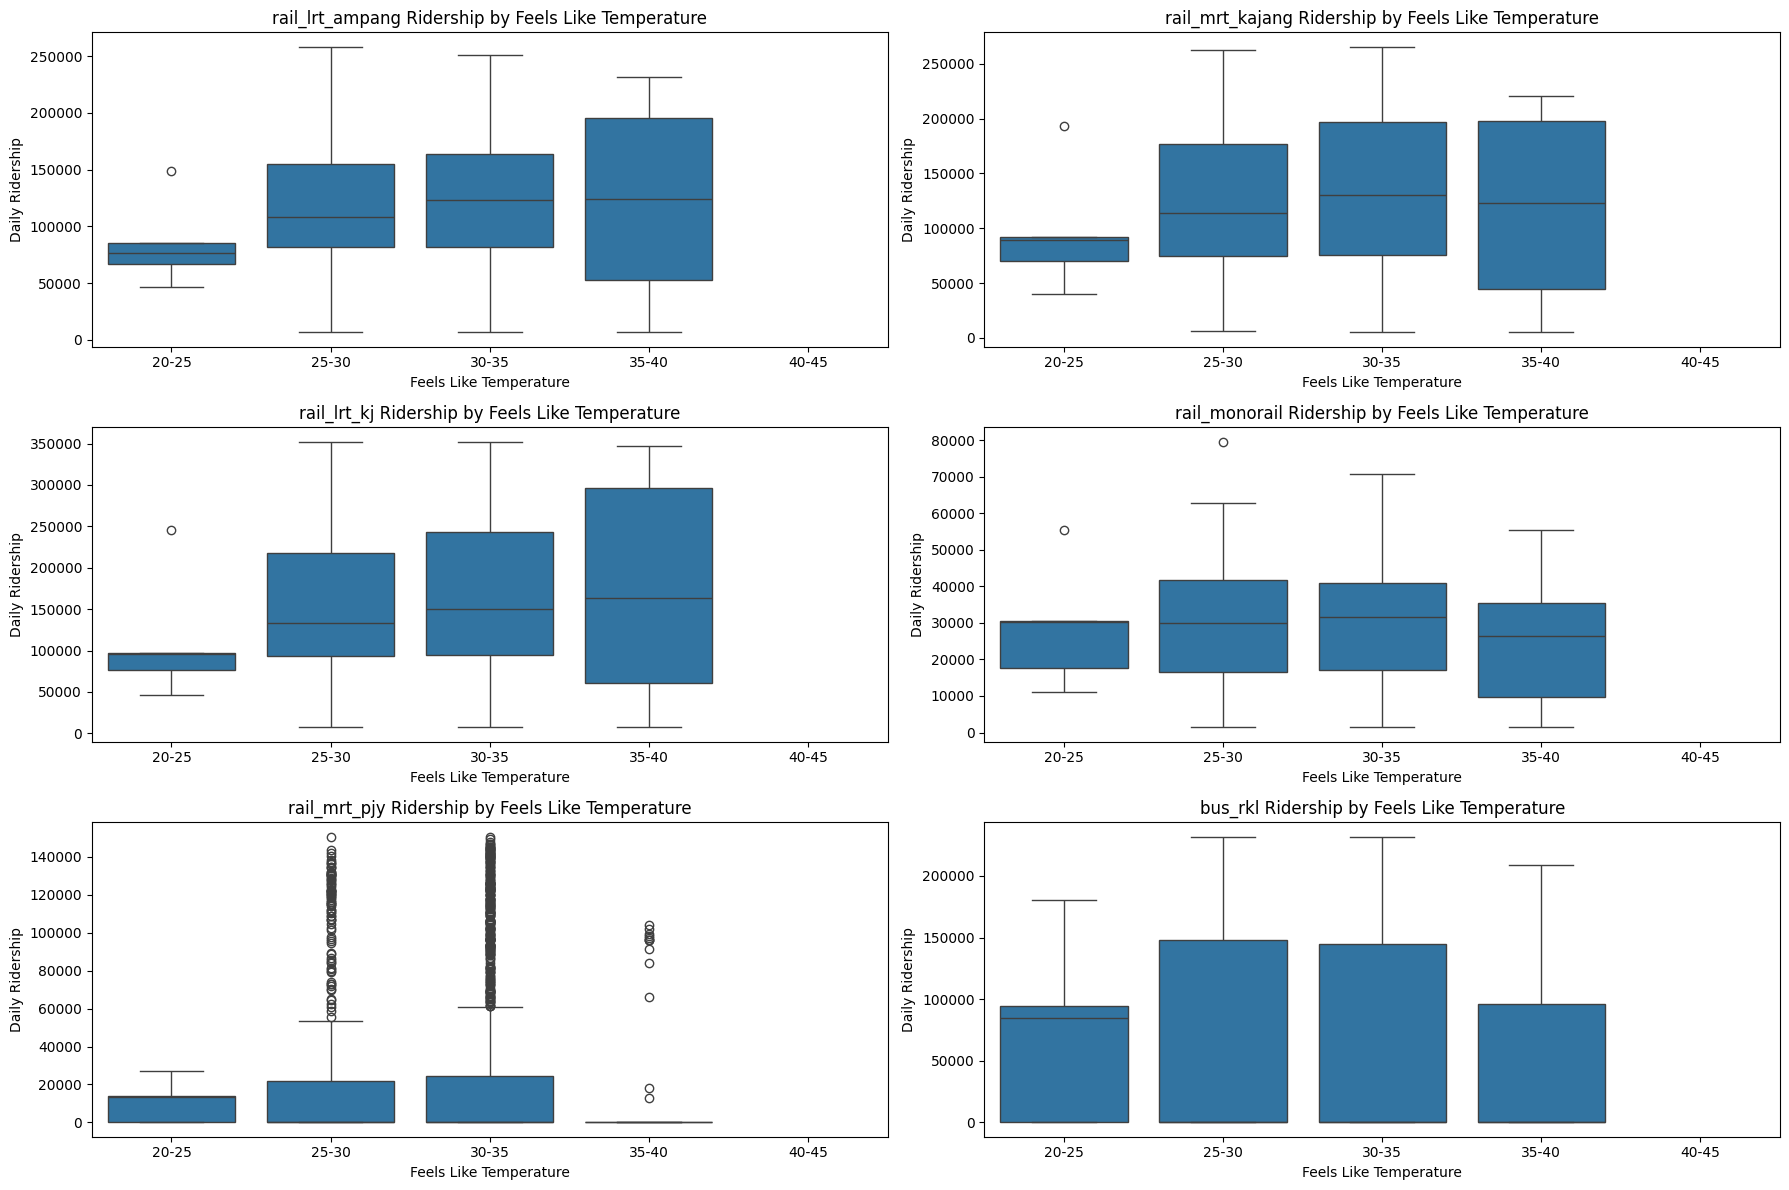

In [ ]:
# Bin the 'feelslike' temperatures into ranges
bins = [20, 25, 30, 35, 40, 45]
labels = ['20-25', '25-30', '30-35', '35-40', '40-45']
df['feelslike_bins'] = pd.cut(df['feelslike'], bins=bins, labels=labels, include_lowest=True)

# Define the list of transport modes
transport_modes = ['rail_lrt_ampang', 'rail_mrt_kajang', 'rail_lrt_kj',
                   'rail_monorail', 'rail_mrt_pjy', 'bus_rkl']

# Create box plots for each mode of transport
plt.figure(figsize=(18, 12))

for i, mode in enumerate(transport_modes, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df, x='feelslike_bins', y=mode)
    plt.title(f'{mode} Ridership by Feels Like Temperature')
    plt.xlabel('Feels Like Temperature')
    plt.ylabel('Daily Ridership')

plt.tight_layout()
plt.show()

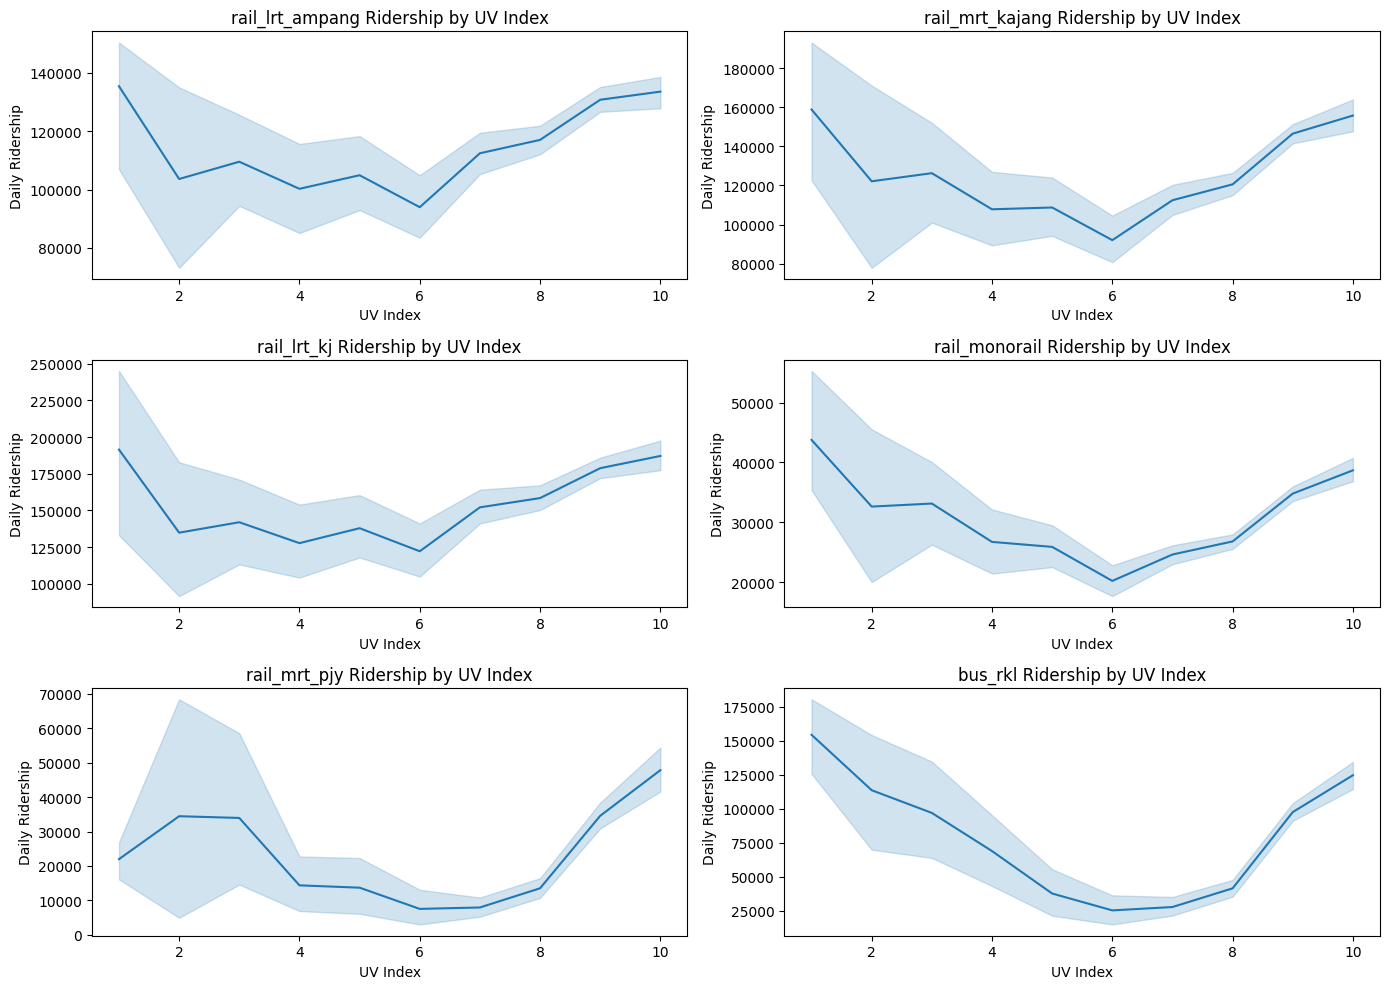

In [ ]:
# Define the list of transport modes
transport_modes = ['rail_lrt_ampang', 'rail_mrt_kajang', 'rail_lrt_kj',
                   'rail_monorail', 'rail_mrt_pjy', 'bus_rkl']

# Create line plots for UV index and ridership for each mode of transport
plt.figure(figsize=(14, 10))

for i, mode in enumerate(transport_modes, 1):
    plt.subplot(3, 2, i)
    sns.lineplot(data=df, x='uvindex', y=mode)
    plt.title(f'{mode} Ridership by UV Index')
    plt.xlabel('UV Index')
    plt.ylabel('Daily Ridership')

plt.tight_layout()
plt.show()

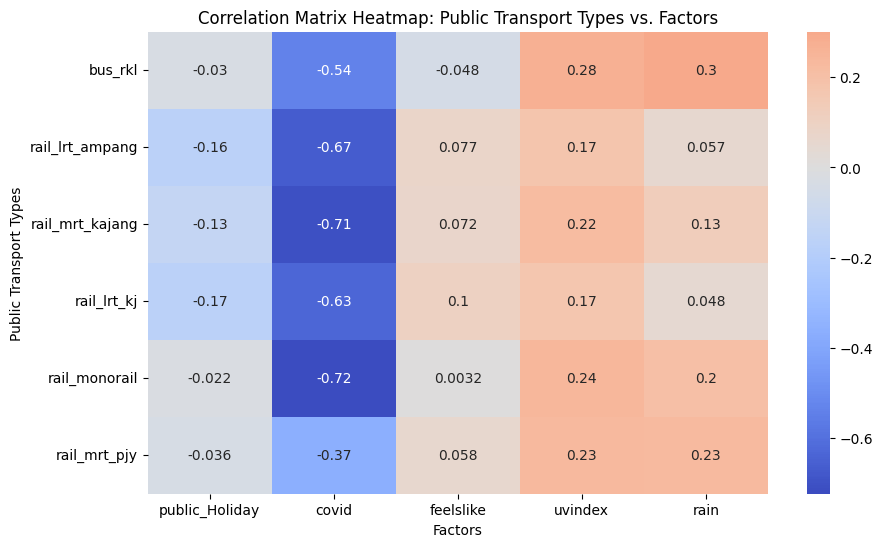

In [ ]:
# Separate the columns into transport types and factors
transport_columns = ['bus_rkl', 'rail_lrt_ampang', 'rail_mrt_kajang', 'rail_lrt_kj', 'rail_monorail', 'rail_mrt_pjy']
factor_columns = ['public_Holiday', 'covid', 'feelslike', 'uvindex', 'rain']

# Ensure 'public_Holiday' and 'rain' are numeric
df['public_Holiday'] = df['public_Holiday'].astype(float)
df['rain'] = df['rain'].astype(float)

# Calculate the correlation matrix only between transport types and factors
corr_matrix = df[transport_columns + factor_columns].corr().loc[transport_columns, factor_columns]

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0, linecolor='black')
plt.title('Correlation Matrix Heatmap: Public Transport Types vs. Factors')
plt.xlabel('Factors')
plt.ylabel('Public Transport Types')
plt.show()